In [40]:
import pandas as pd
import numpy as np
import scipy.special 
import matplotlib.pyplot as plt
import math
from tabulate import tabulate

 # TZ metrics

## Static route stretch

In [47]:
def import_stretch(filename):
    df = pd.read_csv(filename, names=["baseline_stretch", "audited_stretch", "respects_no_valley"], usecols=[0,1,2])
    return df

In [74]:
def crunch_stretch(filename):
    pandas_data = import_stretch(filename)
    static_stretch = pandas_data.to_numpy()
    
    # Filter out paths with same origin and destination
    static_stretch = static_stretch[static_stretch[:,0] > 0,:]
    
    # Filter out <1 stretch paths
    tz_better = static_stretch[static_stretch[:,0] > static_stretch[:,1], :]
    bgp_better = static_stretch[static_stretch[:,0] <= static_stretch[:,1], :]
    
    plt.plot([1, 14], [1, 14], alpha=.5, color="xkcd:slate", zorder=1)
    plt.scatter(bgp_better[:,0], bgp_better[:,1], alpha=.1, label="BGP as reference", zorder=2)
    plt.scatter(tz_better[:,0], tz_better[:,1], alpha=.1, label="TZ as reference", zorder=2)
    plt.xlabel("BGP path length")
    plt.ylabel("TZ path length")
    plt.title("Path lenghts combinations")
    plt.legend()
    
    stretches = static_stretch[:,1].astype(float) / static_stretch[:,0] 
    stretch_distr = np.sort(stretches)
    
    bgp_better_stretch = bgp_better[:,1].astype(float) / bgp_better[:,0]
    
    print("Measured average stretch: %f\tMeasured median stretch: %f\t Paths with valleys: %f\n" % (np.average(stretches), np.median(stretches), np.average(static_stretch[:,2])))
    print("Average stretch (BGP ref): %f\tMedian stretch (BGP ref): %f\t Paths with valleys (BGP ref): %f\n" % (np.average(bgp_better_stretch), np.median(bgp_better_stretch), np.average(bgp_better[:,2])))
    
    stretch_distr = np.array([[x[0], x.shape[0]] for x in np.split(stretch_distr, np.unique(stretch_distr, return_index=True)[1])[1:]])
    stretch_distr[:,1] = stretch_distr[:,1] / float(static_stretch.shape[0])
    
    plt.figure()
    plt.xlabel("TZ stretch")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(stretch_distr[:,0], stretch_distr[:,1], '--o', alpha=.7, label="Stretch PDF")
    plt.plot(stretch_distr[:,0], np.cumsum(stretch_distr[:,1]), ':^', label="Stretch CDF")
    #plt.vlines(1.1, ymin=0, ymax=1, linestyles='dashed', colors=['green'])
    plt.legend()

### < 1 stretch study

In [33]:
spo_GRP_4000 = pd.read_csv("./simulation/data/full-stretch-spo-GRP-4000.csv", names=["baseline_stretch", "audited_stretch", "respects_no_valley", "baseline_nodes", "baseline_types", "audited_nodes", "audited_types"])

In [39]:
spo_GRP_4000.loc[3733]

baseline_stretch                                                     12
audited_stretch                                                       3
respects_no_valley                                                    0
baseline_nodes        29827>209>4637>4657>18106>134809>4788>7473>747...
baseline_types                      1>-1>-1>-1>-1>-1>-1>-1>-1>-1>-1>-1>
audited_nodes                                     29827>209>1299>61170>
audited_types                                                   1>0>-1>
Name: 3733, dtype: object

In [51]:
print("Baseline: \t%s" % np.array(spo_GRP_4000.loc[3733]["baseline_types"].split(">")[:-1]).astype(int))
print("Audited: \t%s" % np.array(spo_GRP_4000.loc[3733]["audited_types"].split(">")[:-1]).astype(int))

Baseline: 	[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Audited: 	[ 1  0 -1]


### Stretch overview

Measured average stretch: 1.063385	Measured median stretch: 1.000000	 Paths with valleys: 0.011657

Average stretch (BGP ref): 1.175066	Median stretch (BGP ref): 1.200000	 Paths with valleys (BGP ref): 0.013055



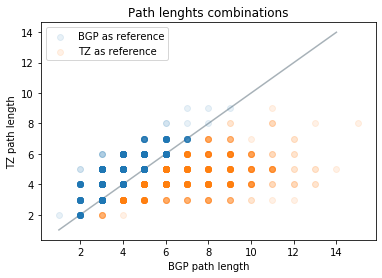

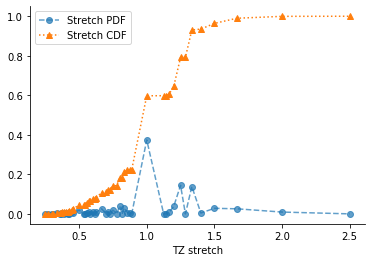

In [75]:
crunch_stretch("./simulation/data/full-stretch-spo-GRP-4000.csv")

Measured average stretch: 1.054610	Measured median stretch: 1.000000	 Paths with valleys: 0.010106

Average stretch (BGP ref): 1.162861	Median stretch (BGP ref): 1.000000	 Paths with valleys (BGP ref): 0.009788



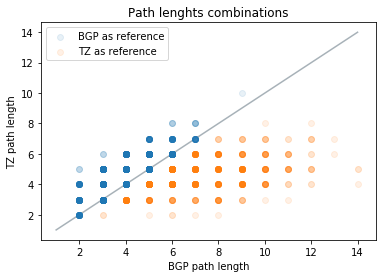

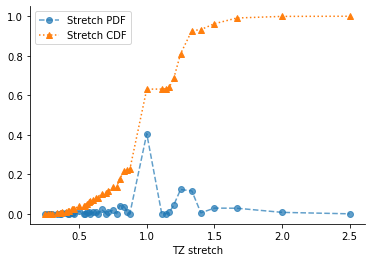

In [76]:
crunch_stretch("./simulation/data/full-stretch-GRP-4000.csv")

Measured average stretch: 1.101602	Measured median stretch: 1.000000	 Paths with valleys: 0.045827

Average stretch (BGP ref): 1.201329	Median stretch (BGP ref): 1.200000	 Paths with valleys (BGP ref): 0.049661



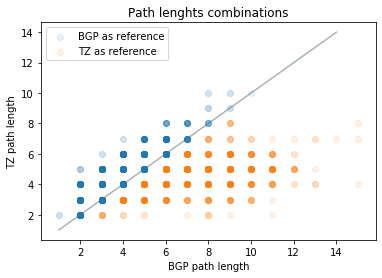

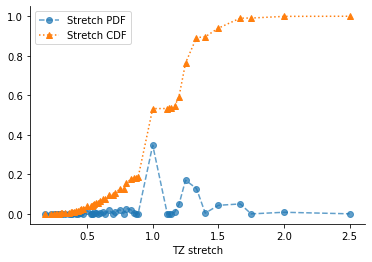

In [77]:
crunch_stretch("./simulation/data/full-stretch-GR-6000.csv")

Measured average stretch: 1.100412	Measured median stretch: 1.000000	 Paths with valleys: 0.015049

Average stretch (BGP ref): 1.204076	Median stretch (BGP ref): 1.250000	 Paths with valleys (BGP ref): 0.016460



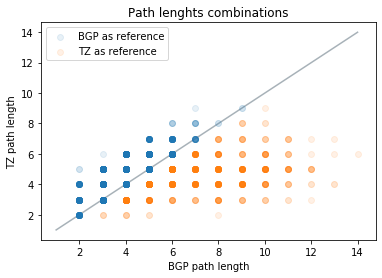

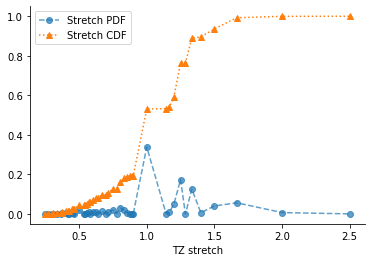

In [78]:
crunch_stretch("./simulation/data/full-GR-stretch-4000.csv")

Measured average stretch: 1.117611	Measured median stretch: 1.000000	 Paths with valleys: 0.150189

Average stretch (BGP ref): 1.227246	Median stretch (BGP ref): 1.250000	 Paths with valleys (BGP ref): 0.157254



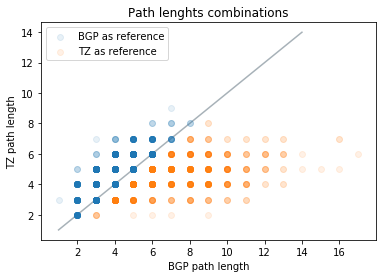

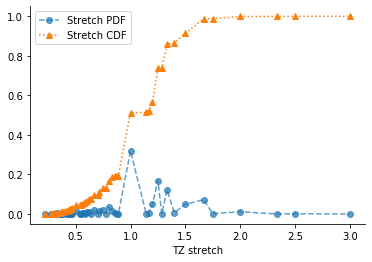

In [79]:
crunch_stretch("./simulation/data/full-GR(not-on-discovery)-stretch-4000.csv")

Measured average stretch: 1.105795	Measured median stretch: 1.000000	 Paths with valleys: 0.115520

Average stretch (BGP ref): 1.217322	Median stretch (BGP ref): 1.250000	 Paths with valleys (BGP ref): 0.119674



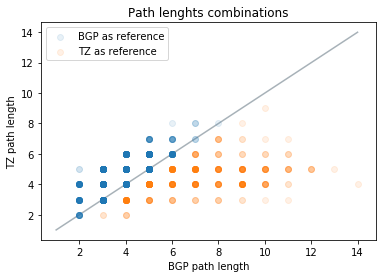

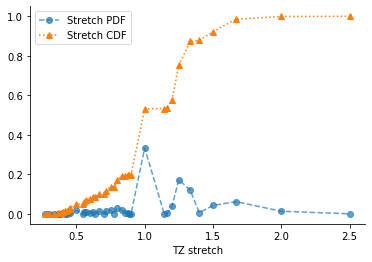

In [80]:
crunch_stretch("./simulation/data/full-stretch-2000.csv")

## Link deletion impact

An impact file contains the following columns
  - `endpoint1` The asn of the first node
  - `endpoint2` The asn of the second node
  - `degree1` The number of links (before deletion) of the 1st node
  - `degree2` The number of links (before deletion) of the 2nd node
  - `impact` The number of nodes that must send/receive updates

In [18]:
def import_impact(filename):
    df = pd.read_csv(filename, names=["endpoint1", "endpoint2", "degree1", "degree2", "impact"], usecols=range(0,5))
    return df

In [19]:
def import_impact_measurements(filename):
    df = pd.read_csv(filename, names=["measure"], usecols=[5])
    return df

In [4]:
# Save impact to file
# link_del_impact.to_csv("./simulation/data/full-impact-2000.csv", index=False, header=False)

#### Impact by degree quotient
Here, I relate the number of updated nodes with the quotient between the maximum and the minimum degree of the endpoints  

In [113]:
def crunch_deletion_impact(filename):
    link_del_impact = import_impact(filename)
    deletion_impact = link_del_impact.to_numpy()
    print(link_del_impact)
    print("Average impact: %.3f \t Maximum impact: %.0f" % (deletion_impact[:,4].mean(), deletion_impact[:,4].max()))
    
    abs_deg_val = np.log(np.maximum(deletion_impact[:,2:3], deletion_impact[:,3:4]))
    degree_quotient_impact = np.concatenate([np.maximum(deletion_impact[:,2:3], deletion_impact[:,3:4])/np.minimum(deletion_impact[:,2:3], deletion_impact[:,3:4]).astype(float), deletion_impact[:,4:5]], axis=1)
    degree_quotient_impact = degree_quotient_impact[np.argsort(degree_quotient_impact[:,0]),:]
    
    # Handle appropriately deletions without updates (y=0)
    zero_impact_quotient_idxs = degree_quotient_impact[:,1] == 0.
    zero_impact_fraction = zero_impact_quotient_idxs.sum() / float(degree_quotient_impact.shape[0])
    zero_impact_deletions = degree_quotient_impact[zero_impact_quotient_idxs, :]
    zero_impact_deletions[:,1] = 1
    degree_quotient_impact = degree_quotient_impact[degree_quotient_impact[:,1] != 0., :]
        
    if zero_impact_quotient_idxs.sum() > 0:
        print("%.2f%% of the link deletions didn't require any update" % (zero_impact_fraction*100))
        print("Average degree quotient of zero-impact deletions:\t %.3f" % (zero_impact_deletions[:,0].mean()))
        zero_impact_idxs = deletion_impact[:,4] == 0.
        print("Average maximum degree of zero-impact deletions:\t %.3f" % (np.maximum(deletion_impact[zero_impact_idxs, 2], deletion_impact[zero_impact_idxs, 3]).mean()))
        print("Average minimum degree of zero-impact deletions:\t %.3f" % (np.minimum(deletion_impact[zero_impact_idxs, 2], deletion_impact[zero_impact_idxs, 3]).mean()))
    
    
    plt.figure(figsize=(8, 6))
    plt.title("Nodes updated by degree quotient")
    plt.scatter(zero_impact_deletions[:,0], zero_impact_deletions[:,1], 60, marker='X', alpha=.1, zorder=10, label="Zero impact")
    # Big point scale: 30
    plt.scatter(degree_quotient_impact[:,0], degree_quotient_impact[:,1], abs_deg_val * .5, alpha=.15, label="Non-zero impact")
    plt.yscale("log")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()
    plt.ylabel("AS updated")
    plt.xlabel("Quotient between degrees of endpoints");
    #plt.savefig("./figs/" + dataset_name + "-deg_quotient.svg")
    
    return degree_quotient_impact, abs_deg_val

       endpoint1  endpoint2  degree1  degree2  impact
0          34224      50039     1745       75       2
1          36351     269546     2829       35       2
2           1103      42676     1354       45       2
3          60501     198224     4472        6       2
4          56911      61568      109     3816       2
...          ...        ...      ...      ...     ...
42212      20562      41412      810       68       2
42213      61595     196925     1252      444       2
42214      31133      49730     1046      425     426
42215       8468      34309      889      195       2
42216     262541     262612        3     1238       2

[42217 rows x 5 columns]
Average impact: 35.778 	 Maximum impact: 25757


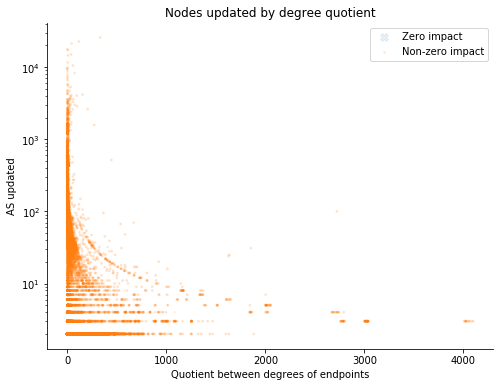

In [111]:
impact_spo_GRP_chosen = crunch_deletion_impact("./simulation/data/full-impact-spo-GRP-chosen.csv")

      endpoint1  endpoint2  degree1  degree2  impact
0         56665      44927     2229      475       2
1        197002      56605        3        2       3
2          6903      51011      427      432       2
3         41722      50952      783       12       2
4         20847      58299      139      218       2
...         ...        ...      ...      ...     ...
2995        174     395474     6041        3       4
2996     133815       4739       86      683       2
2997     138068     138840       31       61       2
2998        174      47927     6040       28      29
2999      11284      48467      462      435       2

[3000 rows x 5 columns]
Average impact: 88.012 	 Maximum impact: 27938


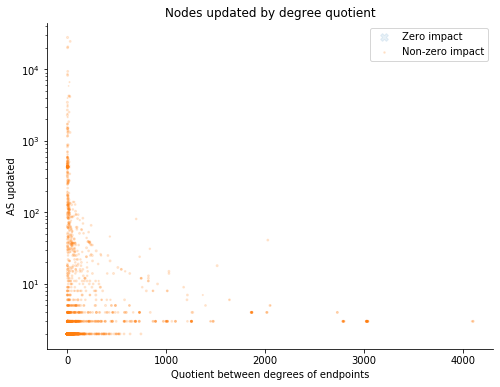

In [112]:
impact_spo_GRP_3000 = crunch_deletion_impact("./simulation/data/full-impact-spo-GRP-3000.csv")

      endpoint1  endpoint2  degree1  degree2  impact
0         59605      12472     1271       16      17
1           278      32098        8      129       9
2          8403       3741      160      745       2
3          6939      26467     8237        2       3
4         48297     202069      432      459       2
...         ...        ...      ...      ...     ...
2995     196925      31323      587      439       2
2996      52436       7303        3      188       4
2997       8339      24516       94     1830      97
2998      52320     268010     1571       11      12
2999      38527     138141       12        2       3

[3000 rows x 5 columns]
Average impact: 65.973 	 Maximum impact: 67959


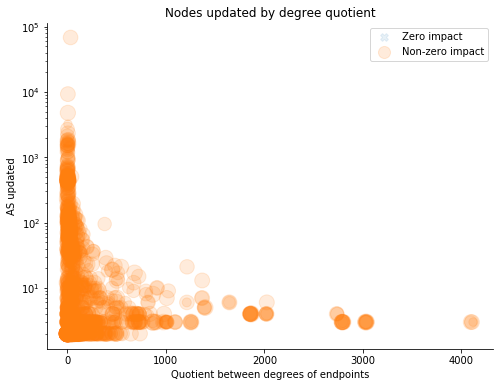

In [7]:
impact_o_GRP_3000 = crunch_deletion_impact("./simulation/data/full-impact-o-GRP-3000.csv")

      endpoint1  endpoint2  degree1  degree2  impact
0           174      13005     6080       51   11684
1         47321      59624      433      505       0
2         52075      34019       88     1593       0
3         12290       3741       59      745   16269
4          8426      24594      894       68       0
...         ...        ...      ...      ...     ...
2995       1273      20705      303        6    8149
2996      45194     136358       32        2     747
2997      50473     199524      506      719       0
2998      48848      49063      428      513       0
2999      47211      49120      439      430       0

[3000 rows x 5 columns]
Average impact: 2101.932 	 Maximum impact: 55330
65.20% of the link deletions didn't require any update
Average degree quotient of zero-impact deletions:	 29.759
Average maximum degree of zero-impact deletions:	 1320.113
Average minimum degree of zero-impact deletions:	 229.263


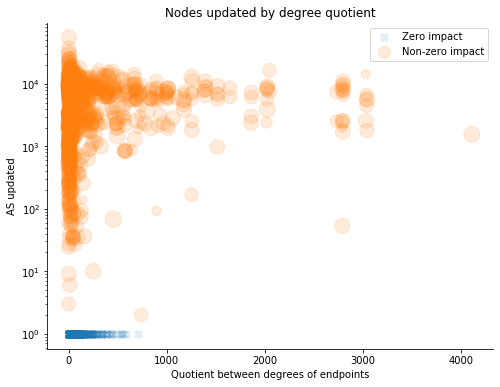

In [8]:
impact_GRP_3000 = crunch_deletion_impact("./simulation/data/full-impact-GRP-3000.csv")

      endpoint1  endpoint2  degree1  degree2  impact
0         63159       3741        2      745       2
1         30421      22773        2      543       2
2         13893        209        3     1791       3
3        263722       4323        3     1487       3
4        267708       4323        2     1486       2
...         ...        ...      ...      ...     ...
3995     132394      63956        7      804       7
3996     204263      51185        6     4270       6
3997     134626       4787        2       60       2
3998     204068      43061        2       79       2
3999      26937       6461        2     1995       2

[4000 rows x 5 columns]
Average impact: 21.908 	 Maximum impact: 13945
5.12% of the link deletions didn't require any update
Average degree quotient of zero-impact deletions:	 19.548
Average maximum degree of zero-impact deletions:	 938.600
Average minimum degree of zero-impact deletions:	 115.683


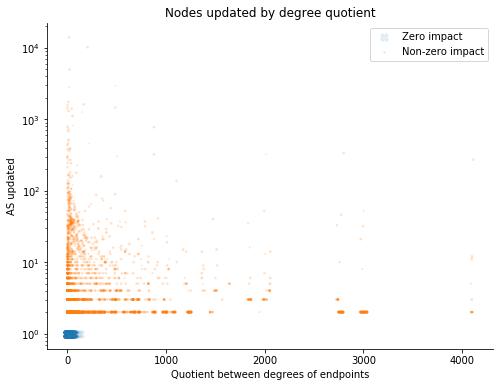

In [115]:
impact_4000 = crunch_deletion_impact("./simulation/data/full-impact-4000.csv")

      endpoint1  endpoint2  degree1  degree2  impact
0          8647      16347      137     1508       0
1        396983       7795        2      106     773
2         31529      51088      611      454    6982
3          5466      25091      135     2430    9446
4         23106      20473     1476      591    9823
...         ...        ...      ...      ...     ...
2995       3549       7243     2187        7    8860
2996     264911      11644     1313       45       0
2997     199624      48914      448      429       0
2998      56665      43436     2208       28       0
2999      45177      55857       73        2   12768

[3000 rows x 5 columns]
Average impact: 3476.268 	 Maximum impact: 66286
44.27% of the link deletions didn't require any update
Average degree quotient of zero-impact deletions:	 10.156
Average maximum degree of zero-impact deletions:	 918.591
Average minimum degree of zero-impact deletions:	 282.368


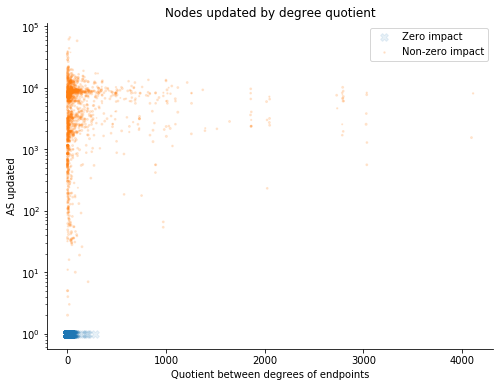

In [117]:
impact_GR_3000 = crunch_deletion_impact("./simulation/data/full-impact-GR-3000.csv")

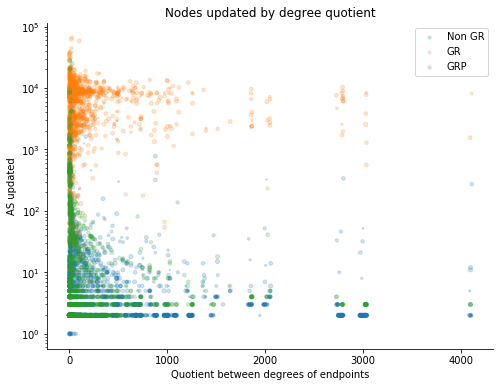

In [120]:
plt.figure(figsize=(8, 6))
plt.title("Nodes updated by degree quotient")
plt.scatter(impact_4000[0][:,0], impact_4000[0][:,1], impact_4000[1] * 2, alpha=.2, label="Non GR")
plt.scatter(impact_GR_3000[0][:,0], impact_GR_3000[0][:,1], impact_GR_3000[1] * 2, alpha=.2, label="GR")
plt.scatter(impact_spo_GRP_3000[0][:,0], impact_spo_GRP_3000[0][:,1], impact_spo_GRP_3000[1] * 2, alpha=.2, label="GRP")
plt.yscale("log")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.ylabel("AS updated")
plt.xlabel("Quotient between degrees of endpoints");
#plt.savefig("./figs/" + dataset_name + "-deg_quotient.svg")

#### Invalidation hop distance

In [20]:
def explode_measures(pands):
    res = []
    for idx, row in enumerate(pands["measure"]):
        for n in row.split("-")[:-1]:
            res.append([idx, n])
    return np.array(res)

In [21]:
def get_measures_by_event(impact_filename):
    del_impact = import_impact_measurements(impact_filename)
    raw_measures = explode_measures(del_impact)
    measures = np.concatenate([raw_measures[:,0:1], np.vectorize(lambda x: x.split("@")[0])(raw_measures[:,1])[..., np.newaxis], np.vectorize(lambda x: x.split("@")[1])(raw_measures[:,1])[...,np.newaxis]], axis=1)
    measures = measures.astype(int)
    print(measures[:10,...])
    measures_by_event = [x[:,1:] for x in np.split(measures, np.unique(measures[:,0], return_index=True)[1])[1:]]
    
    # Sanity check:
    # there are always exactly 2 nodes at distance zero for each event
    assert (apply_func_by_event(measures_by_event, lambda x: (x[:,1] == 0).sum()) != 2).sum() == 0
    
    return measures_by_event

In [22]:
def apply_func_by_event(ms, operator, combinator=None, zero=0):
    if combinator == None:
        result = []
        for x in ms:
            result.append(operator(x))
        return np.array(result)
    else:
        acc = zero
        for x in ms:
            acc = combinator(acc, operator(x))
        return acc

I try with:
  - `measures_spo_GRP_3000`:   3000 random deletions
  - `measures_spo_GRP_chosen`: the edges that when offline between March and April 2020, as measured by CAIDA

In [28]:
measures_spo_GRP_3000 = get_measures_by_event("./simulation/data/full-impact-spo-GRP-3000.csv")
measures_spo_GRP_chosen = get_measures_by_event("./simulation/data/full-impact-spo-GRP-chosen.csv")

[[     0  44927      0]
 [     0  56665      0]
 [     1 197002      0]
 [     1  56605      0]
 [     2   6903      0]
 [     2  51011      0]
 [     3  41722      0]
 [     3  50952      0]
 [     4  20847      0]
 [     4  58299      0]]
[[     0  50039      0]
 [     0  34224      0]
 [     1  36351      0]
 [     1 269546      0]
 [     2   1103      0]
 [     2  42676      0]
 [     3  60501      0]
 [     3 198224      0]
 [     4  56911      0]
 [     4 200807      1]]


In [24]:
def mean_distance(meas_by_evt):
    acc_res = apply_func_by_event(meas_by_evt, lambda x: (x[:,1].sum(), x[:,1].shape[0]), lambda acc, r: (acc[0]+r[0], acc[1]+r[1]), (0, 0))
    mean = float(acc_res[0]) / acc_res[1]
    return mean

In [52]:
def max_distance(meas_by_evt):
    max = apply_func_by_event(meas_by_evt, lambda x: x[:,1].max(), lambda acc, r: acc if r < acc else r)
    return max

In [80]:
# Update distribution (# of ASes)
def draw_update_distribution(meas_by_evt):
    sorted_update_size = np.sort(apply_func_by_event(meas_by_evt, lambda x: x.shape[0]))
    update_distr = np.unique(sorted_update_size, return_counts=True)
    plt.scatter(update_distr[0], update_distr[1]/update_distr[1].sum().astype(float))
    plt.title("Update impact distribution")
    plt.xscale("log")

In [86]:
# Update hop-distance distribution
def draw_hop_distance_distribution(meas_by_evt, data_name=""):
    distance_distr = np.unique(np.sort(np.concatenate(apply_func_by_event(meas_by_evt, lambda x: x[:,1]))), return_counts=True)
    plt.plot(distance_distr[0], distance_distr[1] / distance_distr[1].sum().astype(float), "--o", alpha=.9, label=data_name)

In [58]:
top_level_as = np.array([   174,   3356,   7018,   3549,   1299,   3257,    209,   6461,
         2914,   6939,    701,  12389,   9498,   8220,   9002,  46887,
         4826,   3216,  13101,   6830,   2828,   4755,  20485,   6453,
        16735,   3320,   3491,  22773,  31133,   4766,   6762,  10429,
        12741,   5588,   8359,   7029,   4637,  20115,   1221,   3786,
        32787,   8708,  20473,   7717,   9318,   1239,  54004, 201054,
         4230,   7474,  50607,  20764,   3326, 201053,  55410,   9049,
        10796,   5617,   4809,   7713,   8218,    577,  33491,  12874])

In [59]:
caida_top_64 = np.array([3356,1299,174,3257,2914,6762,6939,6453,3491,6461,1273,3549,9002,5511,4637,12956,7473,209,12389,3320,701,7018,7922,20485,3216,16735,9498,31133,6830,20764,2828,52320,15412,1239,8359,286,43531,58453,10429,262589,28917,37468,4809,4755,7738,33891,31500,41095,4766,8220,4826,11537,7843,18881,29076,34800,46887,4230,5483,20804,4134,8167,267613,7029])

In [64]:
def top_as_updated(meas_by_evt):
    top_level_update = apply_func_by_event(meas_by_evt, lambda x: np.in1d(x[:,0], caida_top_64).sum() > 0).sum()
    return float(top_level_update) / apply_func_by_event(meas_by_evt, lambda x: 1, lambda acc, r: acc+r)

def top_as_incident_edges(meas_by_evt):
    top_level_orig = apply_func_by_event(meas_by_evt, lambda x: (x[np.in1d(x[:,0], caida_top_64), 1] == 0).sum() > 0).sum()
    return float(top_level_orig) / apply_func_by_event(meas_by_evt, lambda x: 1, lambda acc, r: acc+r)

#print("~%.2f%% of events involve the update of a top-level AS (64 most important ones according to ASRank)" % ())
#print("~%.2f%% of events involve the deletion of a link adjacent to a top-level AS (64 most important ones according to ASRank)" % ()

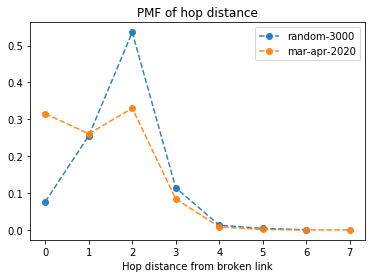

In [105]:
draw_hop_distance_distribution(measures_spo_GRP_3000, "random-3000"), draw_hop_distance_distribution(measures_spo_GRP_chosen, "mar-apr-2020")
plt.xlabel("Hop distance from broken link")
plt.title("PMF of hop distance")
plt.legend();

In [76]:
print(tabulate([
    ["Mean hop-dist", "%.2f" % mean_distance(measures_spo_GRP_3000), "%.2f" % mean_distance(measures_spo_GRP_chosen)],
    ["Max hop-dist", max_distance(measures_spo_GRP_3000), max_distance(measures_spo_GRP_chosen)],
    ["Updates of 64 top-level AS (ASRank)", ("%.2f%%" % (100 * top_as_updated(measures_spo_GRP_3000))), ("%.2f%%" % (100 * top_as_updated(measures_spo_GRP_chosen)))],
    ["Deletion of edges incident on top-level AS", ("%.2f%%" % (100 * top_as_incident_edges(measures_spo_GRP_3000))), ("%.2f%%" % (100 * top_as_incident_edges(measures_spo_GRP_chosen)))]
], headers=["Metric", "random-3000", "mar-apr-2020"]))


Metric                                      random-3000    mar-apr-2020
------------------------------------------  -------------  --------------
Mean hop-dist                               1.75           1.21
Max hop-dist                                6              7
Updates of 64 top-level AS (ASRank)         17.33%         8.56%
Deletion of edges incident on top-level AS  17.27%         8.50%


**Observations**:
  1. top-level ASes are _almost never_ updated if their are not one of the endpoints of the deleted link. This is **positive** since that means the information about the impact does not reach the top-tier ASes
  2. the number of times top ASes are updated is lower in real data than for random simulation. This corresponds to the intuition that **links incident on top-level ASes are less likely to break** (more stable)
  3. The previous observation is consistent with the PDF of the hop-distance: real data from CAIDA have **more abundant deletions that just involve the endpoints** of the deleted edges

In [81]:
np.unique(np.concatenate(apply_func_by_event(measures_by_event, lambda x: x[np.in1d(x[:,0], caida_top_64), 0])), return_counts=True)

(array([   174,    209,    286,    701,   1239,   1273,   1299,   2828,
          2914,   3216,   3257,   3320,   3356,   3491,   3549,   4134,
          4230,   4637,   4755,   4766,   4809,   4826,   5483,   6453,
          6461,   6762,   6830,   6939,   7018,   7029,   7473,   7738,
          7843,   7922,   8167,   8220,   8359,   9002,   9498,  10429,
         11537,  12389,  12956,  15412,  16735,  18881,  20485,  20764,
         20804,  28917,  29076,  31133,  31500,  33891,  34800,  37468,
         41095,  43531,  46887,  52320,  58453, 262589, 267613]),
 array([ 82,  39,  23,  21,   8,  11,  26,  19,  25,  29,  43,  21,  87,
         13,  50,   9,  17,  22,   8,   7,  22,  38,   9,   4,  23,  12,
         27, 233,  24,  13,   7,   9,   2,   6,   4,  51,  33,  21,  36,
         18,   3,  30,   7,  18,  36,  36,  74,  64,  26, 647,  22, 322,
         44, 139, 326, 146, 121, 194,  11,  88,  19,  31, 151], dtype=int64))

## Link deletion stretch increase

File `full-deletion-stretch-2000.csv` was obtained restarting 3 times:
 - after 1383 links deleted
 - after 1687 links deleted

In [40]:
def import_stretch_increase(filename):
    df = pd.read_csv(filename, names=["baseline_before", "audited_before", "baseline_after", "audited_after"])
    return df

In [59]:
def crunch_stretch_increase(filename):
    pd_deletion_stretch = import_stretch_increase(filename)
    deletion_stretch = pd_deletion_stretch.to_numpy().astype(float)
    
    # Measure hops and not nodes
    deletion_stretch = deletion_stretch - 1
    
    stretch_before = deletion_stretch[:,1].astype(float) / deletion_stretch[:,0]
    stretch_after = deletion_stretch[:,3].astype(float) / deletion_stretch[:,2]
    
    bgp_better_idxs = stretch_before >= 1
    tz_better_idxs = stretch_before < 1
    
    # Put stretch_before < 1 samples in different arrays
    tz_better_deletions = deletion_stretch[tz_better_idxs,:]
    tz_better_stretch_before = stretch_before[tz_better_idxs]
    tz_better_stretch_after = stretch_after[tz_better_idxs]
    
    # Remove samples with stretch_before < 1
    deletion_stretch = deletion_stretch[bgp_better_idxs,:]
    stretch_before = stretch_before[bgp_better_idxs]
    stretch_after = stretch_after[bgp_better_idxs]
    
    plt.figure()
    plt.xlabel("Stretch before deletion")
    plt.ylabel("Stretch after deletion")
    plt.scatter(stretch_before, stretch_after, alpha=.4)
    plt.scatter(tz_better_stretch_before, tz_better_stretch_after, alpha=.4)
    
    plt.figure()
    plt.scatter(deletion_stretch[:,1], stretch_after / stretch_before, alpha=.3, zorder=2)
    plt.scatter(tz_better_deletions[:,1], tz_better_stretch_after / tz_better_stretch_before, alpha=.3, zorder=2)
    plt.xlabel("Original TZ length")
    plt.ylabel("Stretch increase")
    plt.yscale("log")
    plt.hlines(1, xmin=1, xmax=5, color="xkcd:pea green", zorder=1)
    return pd_deletion_stretch.to_numpy().astype(float)

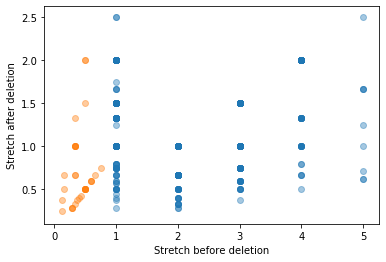

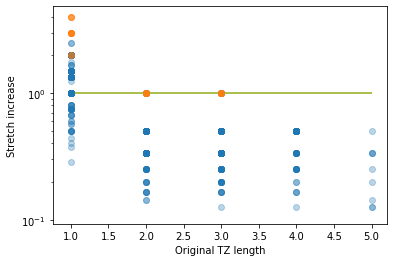

In [60]:
deletion_stretch_spo_GRP = crunch_stretch_increase("./simulation/data/full-deletion-stretch-spo-GRP-1000.csv")

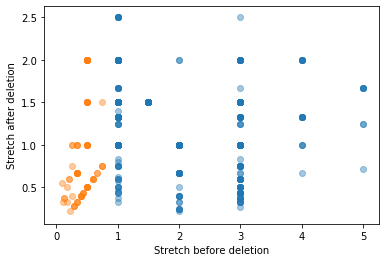

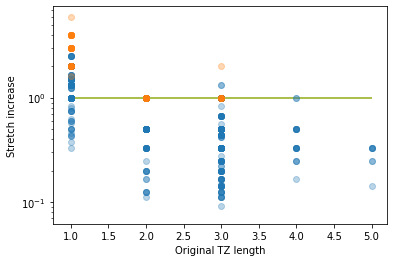

In [58]:
deletion_stretch = crunch_stretch_increase("./simulation/data/full-deletion-stretch-2000.csv")

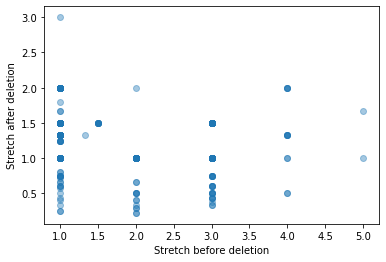

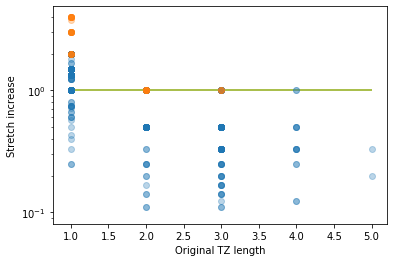

In [55]:
deletion_stretch_GR = crunch_stretch_increase("./simulation/data/full-deletion-stretch-GR-1000.csv")

In [44]:
deletion_stretch_GR[deletion_stretch_GR[:,0]>deletion_stretch_GR[:,1]]

array([[5., 3., 5., 3.],
       [6., 2., 6., 3.],
       [3., 2., 3., 4.],
       [4., 2., 4., 4.],
       [8., 2., 8., 5.],
       [5., 3., 5., 3.],
       [4., 2., 4., 4.],
       [6., 2., 5., 4.],
       [4., 2., 4., 4.],
       [3., 2., 3., 4.],
       [5., 2., 5., 4.],
       [4., 3., 4., 3.],
       [8., 3., 8., 3.],
       [6., 4., 6., 4.],
       [4., 2., 4., 3.],
       [7., 3., 7., 3.],
       [3., 2., 3., 3.],
       [3., 2., 3., 5.],
       [4., 3., 4., 3.],
       [4., 3., 4., 3.],
       [4., 3., 4., 3.],
       [3., 2., 3., 4.],
       [5., 2., 5., 5.],
       [5., 3., 5., 3.],
       [3., 2., 3., 5.],
       [7., 3., 7., 3.],
       [3., 2., 3., 5.],
       [7., 4., 7., 4.],
       [3., 2., 3., 3.],
       [4., 2., 4., 5.],
       [3., 2., 3., 4.],
       [7., 4., 7., 4.],
       [3., 2., 3., 5.],
       [3., 2., 3., 3.],
       [5., 4., 5., 4.],
       [4., 2., 4., 3.],
       [5., 3., 5., 3.],
       [3., 2., 3., 3.],
       [8., 2., 8., 4.],
       [4., 3., 4., 3.],


## Effect of multiple edge deletions on stretch

Starting from `cumulative-deletions-3x.1.csv` the first stretch measurement is performed **before** deleting any links

In [2]:
def import_cumulative_deletions(filename):
    df = pd.read_csv(filename, names=["baseline_stretch", "audited_stretch", "respects_no_valley"])
    return df

In [3]:
def stretch_statistics_by_round(round_data):
    return [(round_data[:,1]/round_data[:,0]).mean(), round_data[:,2].mean()]

In [4]:
def crunch_cumulative_deletions(filename):
    cumul_deletions = import_cumulative_deletions(filename)
    cumul_deletions = cumul_deletions.to_numpy()
    
    # Find lines that mark the beginning of a round (with the form [-round_num, -round_num, -round_num])
    cumul_by_round = np.split(cumul_deletions.astype(float), np.nonzero(np.sum(cumul_deletions, axis=1) < 1)[0])[1:]
    
    # Delete the markers
    cumul_by_round = [rd[1:] for rd in cumul_by_round]
    
    return np.array([stretch_statistics_by_round(r) for r in cumul_by_round]), cumul_by_round[0].shape[0]

In [88]:
# For each simulation, it stores ([[Stretch_by_round, With_valley_by_round] for rounds], samples_num_for_first_round)
cumulative_simulations = {
    "spo-GRP-12xChosen-2000": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-spo-GRP-12xChosen-2000.csv"),
    "spo-GRP-12xChosen": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-spo-GRP-12xChosen.csv"),
    "spo-GRP-7x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-spo-GRP-7x.05.csv"),
    "GRP-3x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-GRP-3x.05-GCloud.csv"),
    "GR-4x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-GR-4x.05-GCloud-(2).csv"),
    "GR-4x.10": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-GR-4x.10-GCloud.csv"),
    "8x.05" :crunch_cumulative_deletions("./simulation/data/cumulative-deletions-8x.05.csv"),
    "9x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-12x.05-(3).csv"),
    "10x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-12x.05-(2).csv"),
    "12x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-12x.05.csv")
}

In [7]:
cumulative_simulations["10x.05"][0][:,0]

array([1.10776464, 1.12204944, 1.15352103, 1.15467974, 1.16002564,
       1.1736178 , 1.18352525, 1.18813442, 1.20109516, 1.19020737,
       1.19957075])

In [8]:
def calculate_x_labels(deletion_proportion, number_of_epochs):
    full_edges_num = 466982
    return [100 * deletion_proportion * (math.pow(1 - deletion_proportion, k)-1) / float(-deletion_proportion) for k in range(0, number_of_epochs)]

In [9]:
def calculate_chosen_x_labels(deletions_number, number_of_epochs):
    full_edges_num = 466982
    return [100 * k * float(deletions_number) / (full_edges_num * number_of_epochs) for k in range(0, number_of_epochs)]

Text(0, 0.5, 'Average stretch')

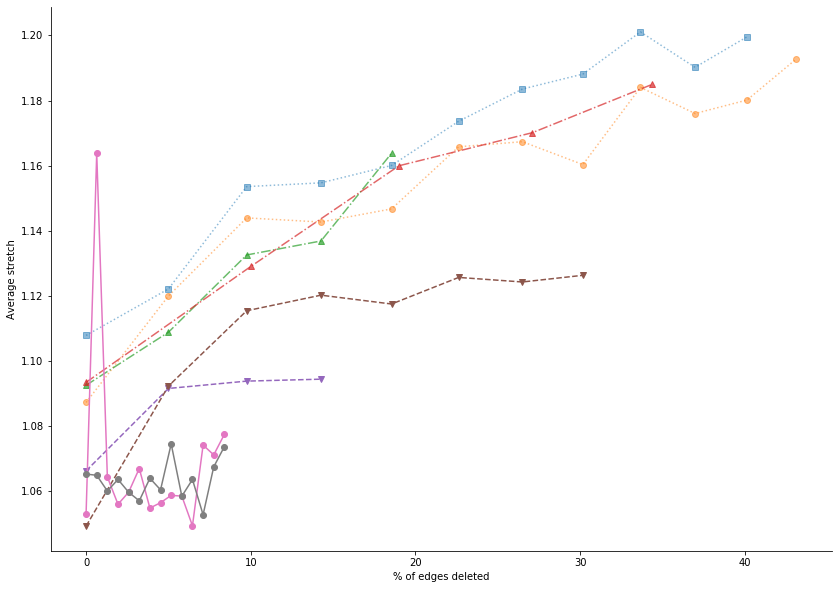

In [103]:
plt.figure(figsize=(14, 10))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(calculate_x_labels(.05, 11), cumulative_simulations["10x.05"][0][:,0], ':s', alpha=.5, zorder=4)
plt.plot(calculate_x_labels(.05, 12), cumulative_simulations["12x.05"][0][:,0], ':o', alpha=.5, zorder=4)
plt.plot(calculate_x_labels(.05, 5), cumulative_simulations["GR-4x.05"][0][:,0], '-.^', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.1, 5), cumulative_simulations["GR-4x.10"][0][:,0], '-.^', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.05, 4), cumulative_simulations["GRP-3x.05"][0][:,0], '--v', alpha=1, zorder=15)
plt.plot(calculate_x_labels(.05, 8), cumulative_simulations["spo-GRP-7x.05"][0][:,0], '--v', alpha=1, zorder=15)
#Deletions: 42848 - 622
plt.plot(calculate_chosen_x_labels(42226, 14), cumulative_simulations["spo-GRP-12xChosen"][0][:,0], '-o', alpha=1, zorder=20)
plt.plot(calculate_chosen_x_labels(42226, 14), cumulative_simulations["spo-GRP-12xChosen-2000"][0][:,0], '-o', alpha=1, zorder=20)
plt.xlabel("% of edges deleted")
plt.ylabel("Average stretch")

Text(0, 0.5, 'Fraction of paths with valleys')

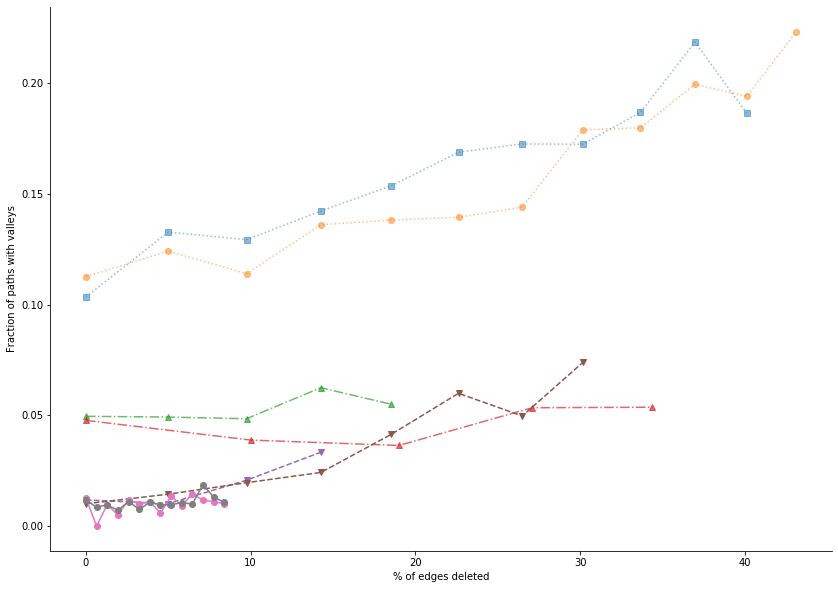

In [102]:
plt.figure(figsize=(14, 10))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(calculate_x_labels(.05, 11), cumulative_simulations["10x.05"][0][:,1], ':s', alpha=.5, zorder=4)
plt.plot(calculate_x_labels(.05, 12), cumulative_simulations["12x.05"][0][:,1], ':o', alpha=.5, zorder=4)
plt.plot(calculate_x_labels(.05, 5), cumulative_simulations["GR-4x.05"][0][:,1], '-.^', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.1, 5), cumulative_simulations["GR-4x.10"][0][:,1], '-.^', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.05, 4), cumulative_simulations["GRP-3x.05"][0][:,1], '--v', alpha=1, zorder=15)
plt.plot(calculate_x_labels(.05, 8), cumulative_simulations["spo-GRP-7x.05"][0][:,1], '--v', alpha=1, zorder=15)
plt.plot(calculate_chosen_x_labels(42226, 14), cumulative_simulations["spo-GRP-12xChosen"][0][:,1], '-o', alpha=1, zorder=20)
plt.plot(calculate_chosen_x_labels(42226, 14), cumulative_simulations["spo-GRP-12xChosen-2000"][0][:,1], '-o', alpha=1, zorder=20)
plt.xlabel("% of edges deleted")
plt.ylabel("Fraction of paths with valleys")